### Using base model to apply Arutema's method and train a new model on a new dataset of predicted images that the base model was originally able to predict correctly within a certain threshold.

### Idea came from here: https://www.kaggle.com/c/prostate-cancer-grade-assessment/discussion/169143

### Step 1: Upload base model and run predictions on dataset

In [1]:
!pip install efficientnet_pytorch torchtoolbox
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

     |████████████████████████████████| 58 kB 2.4 MB/s 
     |████████████████████████████████| 876 kB 8.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=638af241e4026de4f2546c5000ad7147555f2e14d2e9f27a2995ece4b56acd1e
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
  Created wheel for lmdb: filename=lmdb-1.0.0-cp37-cp37m-linux_x86_64.whl size=276741 sha256=f98118fa98af5d1284f21a362bfcfcad3bf45cfa9a71031189dc0adf653f5993
  Stored in directory: /root/.cache/pip/wheels/12/e2/8d/261e2b6143cc3e0e690ccc065af68e44c43c26bc903ffa5d69
Successfully built efficientnet-pytorch lmdb
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-8k3z167h
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl siz

In [2]:
# Imports here
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import os
import random
import math
import skimage.io
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
import time

# Tiff visualisation imports and downloads
import numpy as np
import tifffile as tiff

# For re-importing python modules
import importlib
#importlib.reload(csv_loader.py)

#for quadratic score calculator
from sklearn.metrics import cohen_kappa_score


In [3]:
#use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
# Creating ability to control how many pictures go into the training sample. For debugging / training purposes
sample_size = 10616
df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv').copy().sample(sample_size)
df.to_csv("sample.csv", sep=",", index=False)

In [5]:
class load_csv(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)# todo remove sample for debug
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
        
    
    def __getitem__(self, index):
        image_id = self.annotations.iloc[index, 0]
        img_path = os.path.join(self.root_dir, str(image_id) +".png")
        image = torch.from_numpy(skimage.io.imread(img_path)).permute(2,0,1).float()
        isup_grade = int(self.annotations.iloc[index,:]['isup_grade'])
        
        label = np.zeros(5).astype(np.float32)
        label[:isup_grade] = 1.
        
        #label = np.zeros(6).astype(np.float32)
        #y_label = label[isup_grade] = 1.
        #y_label = torch.tensor(y_label)
        
        self.transform= transforms.Compose([transforms.ToPILImage(),
                                            transforms.ToTensor()])
                                            
        if self.transform:
            image = self.transform(image)
        
        return (image, torch.tensor(label), image_id)

In [6]:
# Loading csv dataset into the dataset loader function load_csv. 
dataset = load_csv(csv_file='sample.csv', root_dir='../input/prostate-cancer-tiles-4x4x128px-downsampling-4x/train_128x4x4_res1/train_128x4x4_res1')

# Creating sample subsets for validation and testing datasets
sample_size = dataset.annotations.shape[0]
train_ratio = .80
valid_ratio = .10
test_ratio = 1-(train_ratio + valid_ratio)
train_size = int(train_ratio*sample_size)
valid_size = int(valid_ratio*sample_size)
test_size = sample_size - train_size - valid_size

# Defining different datasets and respective dataloaders
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Defining different loaders according to database that they're loading
entire_set_loader = torch.utils.data.DataLoader(dataset, batch_size=35, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=35, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=35, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=35, shuffle=False)


In [7]:
# Loading model
model = EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load("../input/efficientnet-pytorch/efficientnet-b0-08094119.pth"))
model._fc = nn.Sequential(nn.Linear(model._fc.in_features, 216),
                          nn.ReLU(),
                          nn.Linear(216, 36, bias=True),
                          nn.ReLU(),
                          nn.Linear(36, 5, bias=True))

# Model path
model_path = '../input/200912-base-model-w-logits/base_model_w_logits.pth'

# Load checkpoint
checkpoint = torch.load(model_path)

# Load model parameters
model.load_state_dict(checkpoint['model_state_dict'])
model._fc.load_state_dict(checkpoint['classifier_state_dict'])

# Load other model related components
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()


if torch.cuda.is_available():
    model = model.cuda()




In [8]:
def validate_data_function(model, test_loader, criterion):
    test_loss = 0
    accuracy = 0
    image_id_list = []
    pred_y_int_list = []
    pred_y_dec_list = []
    y_labels = []
    loss_list = []
    
    model.eval()
    with torch.no_grad():
        for ii, (inputs, labels, image_id) in enumerate(test_loader):
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            output = model.forward(inputs)
            loss = criterion(output,labels)
        
            image_id_list.append(image_id)
        
            pred_y_int = output.sigmoid().sum(1).round().detach()
            pred_y_int_list.append(pred_y_int)
        
            pred_y_dec = output.sigmoid().sum(1).detach()
            pred_y_dec_list.append(pred_y_dec)
            
            y_labels.append(labels.sum(1))
                
            loss_np = loss.detach().cpu().numpy()
            loss_list.append(loss_np)
    
    image_id_list = [j for i in image_id_list for j in i]
    pred_y_int_list = torch.cat(pred_y_int_list).cpu().numpy()
    pred_y_dec_list = torch.cat(pred_y_dec_list).cpu().numpy()
    y_labels = torch.cat(y_labels).cpu().numpy()
    
    test_loss = np.mean(loss_list)
    accuracy = np.mean(pred_y_int_list == y_labels) * 100.
    
    return test_loss, accuracy, image_id, image_id_list, pred_y_int_list, pred_y_dec_list, y_labels

In [9]:
with torch.no_grad():
    test_loss, accuracy, image_id, image_id_list, pred_y_int_list, pred_y_dec_list, y_label_list = validate_data_function(model, entire_set_loader, criterion)
            
print("Base model accuracy: {:.2f}%".format(accuracy))

Base model accuracy: 89.49%


### Our base model's accuracy is printed directly above. The accuracy is of predictions that were obtained by committing a fatal sin: running predictions on training data. This is part of the Arutema method. In the next step, I will explain how I expect to atone for my data training transgressions and keep testing/training data separate.

### Step 2: Define keep/remove datasets. Keep dataset will be training set. Remove dataset will be testing set.

In [10]:
new_df = pd.DataFrame({'image_id': image_id_list,
                       'pred_y_int': pred_y_int_list,
                       'pred_y_dec': pred_y_dec_list,
                       'isup_grade': y_label_list
                       })

# Defining threshold and keeping/removing images accordingly
threshold = 1.6
new_df['thresh_gap'] = [np.abs(x-y) for x, y in zip(new_df['isup_grade'], new_df['pred_y_dec'])]
new_df['passed_thresh'] = [1 if x <= threshold else 0 for x in new_df['thresh_gap']]

new_df_keep = new_df[new_df['thresh_gap']<= threshold]
new_df_remove = new_df[new_df['thresh_gap']> threshold]

new_df_keep.to_csv("sample_keep.csv", sep=",", index=False)
new_df_remove.to_csv("sample_remove.csv", sep=",", index=False)

In [11]:
new_df.passed_thresh.value_counts()

1    10342
0      274
Name: passed_thresh, dtype: int64

Text(0, 0.5, 'ISUP Prediction (y_pred)')

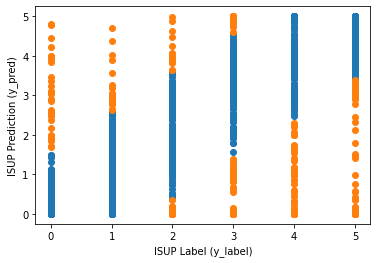

In [12]:
plt.scatter(new_df_keep['isup_grade'], new_df_keep['pred_y_dec'])
plt.scatter(new_df_remove['isup_grade'], new_df_remove['pred_y_dec'])
plt.xlabel('ISUP Label (y_label)')
plt.ylabel('ISUP Prediction (y_pred)')

### Now only loading "keep" images to train a new model

In [13]:
# Loading ONLY KEEP csv dataset into the dataset loader function load_csv. 
sample_size = len(new_df_keep)
train_ratio = .80
valid_ratio = .10
test_ratio = 1-(train_ratio + valid_ratio)
train_size = int(train_ratio*sample_size)
valid_size = int(valid_ratio*sample_size)
test_size = sample_size - train_size - valid_size

keep_dataset = load_csv(csv_file='./sample_keep.csv', root_dir='../input/prostate-cancer-tiles-4x4x128px-downsampling-4x/train_128x4x4_res1/train_128x4x4_res1')

keep_train_set, keep_valid_set, keep_test_set = torch.utils.data.random_split(keep_dataset, [train_size, valid_size, test_size])

remove_dataset = load_csv(csv_file='./sample_remove.csv', root_dir='../input/prostate-cancer-tiles-4x4x128px-downsampling-4x/train_128x4x4_res1/train_128x4x4_res1')

keep_loader = torch.utils.data.DataLoader(keep_dataset, batch_size=30, shuffle=False)
keep_train_loader = torch.utils.data.DataLoader(keep_dataset, batch_size=30, shuffle=False)
keep_valid_loader = torch.utils.data.DataLoader(keep_dataset, batch_size=30, shuffle=False)
keep_test_loader = torch.utils.data.DataLoader(keep_dataset, batch_size=30, shuffle=False)
remove_loader = torch.utils.data.DataLoader(remove_dataset, batch_size=30, shuffle=False)

In [14]:
# Creating model and uploading/creating needed training components
arutema_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=5)
arutema_model._fc = nn.Sequential(nn.Linear(arutema_model._fc.in_features, 216),
                          nn.ReLU(),
                          nn.Linear(216, 36, bias=True),
                          nn.ReLU(),
                          nn.Linear(36, 5, bias=True))


if torch.cuda.is_available():
    arutema_model = arutema_model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [15]:
init_lr = 3e-3
warmup_factor = 10

warmup_epo = 1
n_epochs = 30

#optimizer = optim.Adam(model.parameters())
optimizer = optim.Adam(arutema_model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

criterion = nn.BCEWithLogitsLoss()

In [16]:
# Training parameters and t=0 inputs
print_every = 250
steps = 0
test_loss = 0
output_list = []
label_list = []

# May the training begin!
for epoch in range(1, n_epochs+1):
    arutema_model.train()
    running_loss = 0
    steps = 0
    num_examples = 0
    hits = 0
    
    start = time.time()

    scheduler.step(epoch-1)
    
    for ii, (inputs, labels, image_id) in enumerate(keep_train_loader):
        steps += 1
        num_examples += inputs.shape[0]
                
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
       
        outputs = arutema_model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        
        with torch.no_grad():
            hits+= (outputs.sum(1).round() == labels.sum(1)).float().sum()
        
        if steps % print_every == 0:
            arutema_model.eval()
            
            train_accuracy=0.0
            
            with torch.no_grad():
                valid_loss, accuracy, image_id, image_id_list, pred_y_int_list, pred_y_dec_list, y_label_list = validate_data_function(arutema_model, keep_valid_loader, criterion)
                train_accuracy = hits*100.0/num_examples
                #train_accuracy = equality.type(torch.FloatTensor)/steps * 100.
                end = time.time()
                train_time = end - start
                train_time = train_time / print_every
                
            epoch_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch: {epoch}/{n_epochs}..|"
                  f"# of batches: {steps:.0f}..|"
                  f"lr: {epoch_lr:.6f}..|"
                  f"Train loss: {running_loss/num_examples:.3f}..|"
                  f"Train acc.: {train_accuracy:.3f}..| "
                  f"Valid. loss: {valid_loss:.3f}..|"                  
                  f"Valid. acc.: {accuracy:.3f}|"
                  f"Time (min): {train_time/60: .3f}..|"
                 )
            
            
            
            # running_loss = 0
            arutema_model.train()
    
    path = 'Arutema_base_model_w_logits.pth'
    torch.save({
            'epoch': epoch,
            'model_state_dict': arutema_model.state_dict(),
            'classifier_state_dict': arutema_model._fc.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path)
    
    
    arutema_model.cuda() # moving model to GPU for further training        

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Epoch: 1/30..|# of batches: 250..|lr: 0.000300..|Train loss: 0.013..|Train acc.: 3.920..| Valid. loss: 0.352..|Valid. acc.: 30.971|Time (min):  0.045..|
Epoch: 2/30..|# of batches: 250..|lr: 0.003000..|Train loss: 0.013..|Train acc.: 3.627..| Valid. loss: 0.541..|Valid. acc.: 28.099|Time (min):  0.045..|
Epoch: 3/30..|# of batches: 250..|lr: 0.000300..|Train loss: 0.010..|Train acc.: 2.053..| Valid. loss: 0.253..|Valid. acc.: 52.224|Time (min):  0.044..|
Epoch: 4/30..|# of batches: 250..|lr: 0.002965..|Train loss: 0.011..|Train acc.: 2.093..| Valid. loss: 0.318..|Valid. acc.: 36.763|Time (min):  0.045..|
Epoch: 5/30..|# of batches: 250..|lr: 0.002921..|Train loss: 0.010..|Train acc.: 1.867..| Valid. loss: 0.420..|Valid. acc.: 34.926|Time (min):  0.045..|
Epoch: 6/30..|# of batches: 250..|lr: 0.002861..|Train loss: 0.009..|Train acc.: 1.853..| Valid. loss: 0.423..|Valid. acc.: 48.114|Time (min):  0.045..|
Epoch: 7/30..|# of batches: 250..|lr: 0.002785..|Train loss: 0.009..|Train acc.: 1

In [17]:
with torch.no_grad():
    test_loss, accuracy, image_id, image_id_list, pred_y_int_list, pred_y_dec_list, y_labels = validate_data_function(arutema_model, keep_test_loader, criterion)

print("Test set accuracy: {:.2f}%".format(float(accuracy)))

Test set accuracy: 97.95%


In [18]:
with torch.no_grad():
    test_loss, accuracy, image_id, image_id_list, pred_y_int_list, pred_y_dec_list, y_labels = validate_data_function(arutema_model, remove_loader, criterion)

print("Remove set accuracy: {:.2f}%".format(float(accuracy)))

Remove set accuracy: 10.95%


### Remember, the test set (see accuracy above) is the "new_df_remove" dataset, which is data that fell outside of the Arutema threshold, which means that not only was the base model unable to correctly predict these images (ie. 0% accuracy), but failed to predict correctly beyond a reasonable threshold.

In [19]:
with torch.no_grad():
    test_loss, accuracy, image_id, image_id_list, pred_y_int_list, pred_y_dec_list, y_label_list = validate_data_function(arutema_model, entire_set_loader, criterion)
            
print("New model accuracy on entire dataset: {:.2f}%".format(accuracy.item()))

New model accuracy on entire dataset: 95.70%
